# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.
2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop`*
3. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability


In [1]:
from ema_workbench import (RealParameter, ScalarOutcome, Constant,
                           Model, MultiprocessingEvaluator, ema_logging,
                           perform_experiments)
from lakemodel_function import lake_problem
from ema_workbench.analysis import prim

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

# Setup the model
lake_model = Model('Lakemodel', function=lake_problem)

lake_model.uncertainties = [RealParameter('b',0.1,0.45),
                           RealParameter('q',2.0,4.5),
                           RealParameter('mean',0.01,0.05),
                           RealParameter('stdev',0.001,0.005),
                           RealParameter('delta',0.93,0.99)]

lake_model.levers = [RealParameter('l'+str(i),0,0.1) for i in range(100)]

lake_model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('intertia'),
                  ScalarOutcome('reliability')]

In [3]:
# run model
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=10)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [4]:
# drop the lever columns
experiments.drop(('l'+str(i) for i in range(100)), axis=1, inplace=True)

In [5]:
# drop other columns
experiments.drop(['model', 'policy', 'scenario'], axis=1, inplace=True)

In [6]:
# scenario discovery using prim
x = experiments
tres = np.quantile(outcomes['reliability'], q=0.1)
y = outcomes['reliability'] <= tres

In [7]:
sum(y)

780

In [14]:
# apply prim
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 780 cases of interest
[MainProcess/INFO] mean: 0.8, mass: 0.052, coverage: 0.5333333333333333, density: 0.8 restricted_dimensions: 5


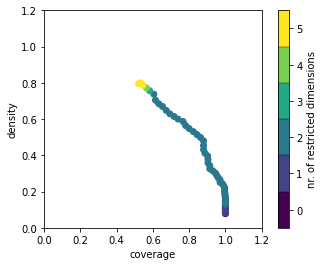

In [15]:
box1.show_tradeoff()
plt.show()

coverage    0.823077
density     0.530579
id                40
mass           0.121
mean        0.530579
res_dim            2
Name: 40, dtype: object

     box 40                                           
        min       max                        qp values
q  2.000414  2.800128    [-1.0, 1.58830932792485e-160]
b  0.100129  0.238070  [-1.0, 3.9060524455678464e-125]



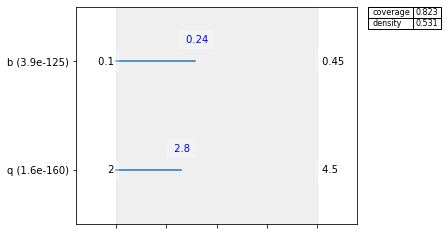

In [16]:
box1.inspect(40)
box1.inspect(40, style='graph')
plt.show()

## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

In [11]:
from ema_workbench.analysis import dimensional_stacking

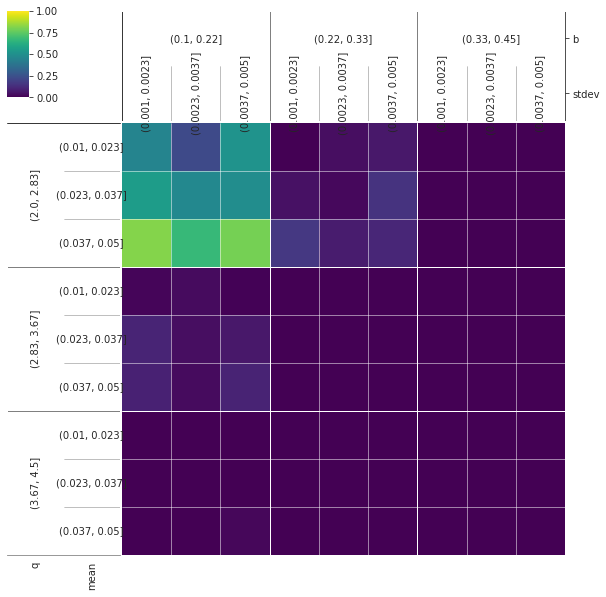

In [17]:
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3, bin_labels=True)
plt.show()

#Conclusions:

- b and 1 seem to be the most important here.
- The values of interest seem to be found when b is low (between 0.1 and 0.22) and q is between 2 and 2.83.
- This is both pointed out by Prim and the Dimensional Stacking.